## FRAUD DETECTION

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

from imblearn.over_sampling import SMOTE

import joblib

In [19]:
df = pd.read_csv("Fraud_Analysis_Dataset.csv")
df_raw = df.copy()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            11142 non-null  int64  
 1   type            11142 non-null  object 
 2   amount          11142 non-null  float64
 3   nameOrig        11142 non-null  object 
 4   oldbalanceOrg   11142 non-null  float64
 5   newbalanceOrig  11142 non-null  float64
 6   nameDest        11142 non-null  object 
 7   oldbalanceDest  11142 non-null  float64
 8   newbalanceDest  11142 non-null  float64
 9   isFraud         11142 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 870.6+ KB


In [23]:
## View some sample data
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


## Exploratory Data Analysis

In [26]:
## Statistical Information
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,11142.000000,1.114200e+04,1.114200e+04,1.114200e+04,1.114200e+04,1.114200e+04,11142.000000
mean,8.717645,2.131915e+05,9.241173e+05,8.249576e+05,8.883541e+05,1.103211e+06,0.102495
std,16.067479,7.600650e+05,2.143004e+06,2.089894e+06,2.601376e+06,2.982447e+06,0.303312
min,1.000000,2.390000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,2.000000,4.946618e+03,4.270000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,6.000000,1.676126e+04,2.816950e+04,4.420605e+03,0.000000e+00,0.000000e+00,0.000000
75%,7.000000,1.543366e+05,3.040855e+05,1.114126e+05,2.711555e+05,3.186374e+05,0.000000
max,95.000000,1.000000e+07,1.990000e+07,1.300000e+07,3.300000e+07,3.460000e+07,1.000000


In [28]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [30]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

if df.isnull().sum().any():
    df.fillna(method='ffill', inplace=True)

Missing Values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64


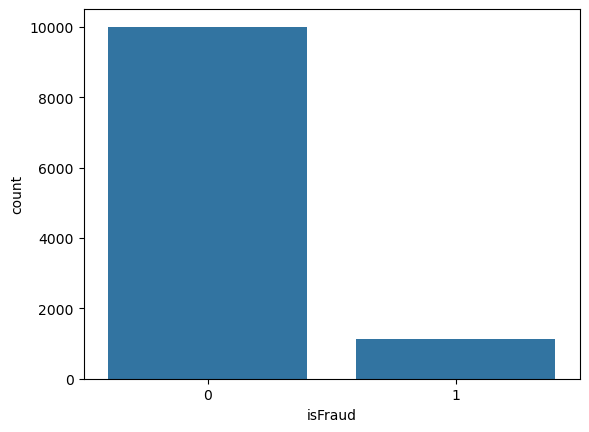

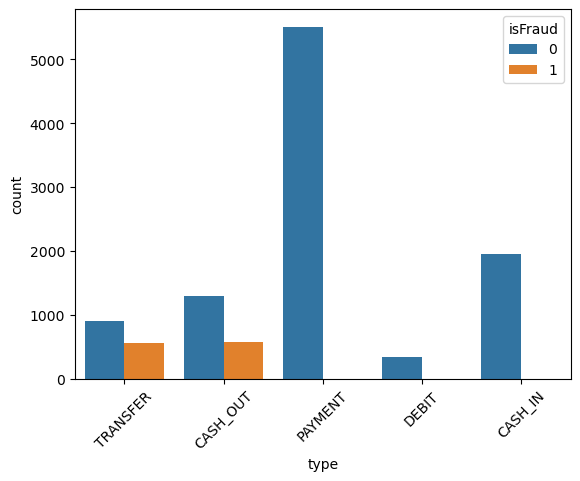

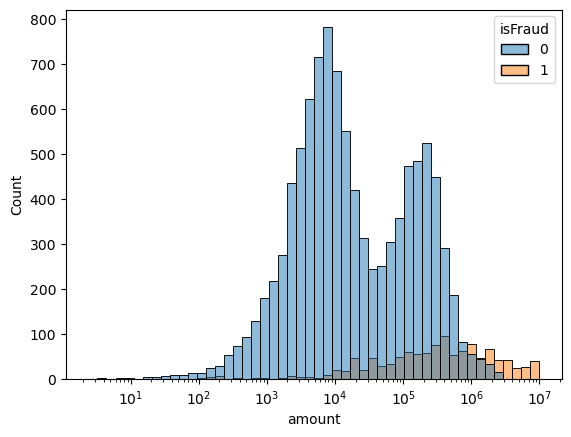

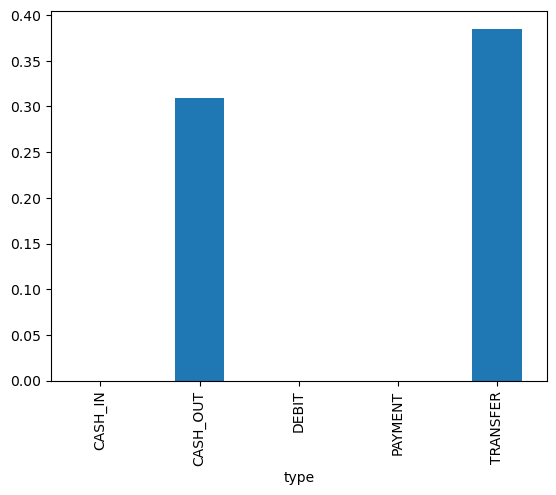

In [32]:
sns.countplot(x='isFraud', data=df_raw)
plt.show()

sns.countplot(x='type', hue='isFraud', data=df_raw)
plt.xticks(rotation=45)
plt.show()

sns.histplot(data=df_raw, x="amount", hue="isFraud", log_scale=True)
plt.show()

df_raw.groupby('type')['isFraud'].mean().plot(kind='bar')
plt.show()

In [33]:
df["isMerchantDest"] = df["nameDest"].str.startswith("M").astype(int)

df["orig_balance_change"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["dest_balance_change"] = df["newbalanceDest"] - df["oldbalanceDest"]

df.drop(["nameOrig","nameDest"], axis=1, inplace=True)

df = pd.get_dummies(df, columns=["type"], drop_first=True)

In [36]:
## Split Features
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

## Train Test Split

In [39]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)

## Preprocessor

In [42]:
num_cols = X_train.columns

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), num_cols)
])

In [44]:
models = {

"Logistic Regression": Pipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000))
]),

"Random Forest": Pipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
]),

"Gradient Boosting": Pipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', GradientBoostingClassifier())
]),

"XGBoost": Pipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(eval_metric='logloss'))
])

}

## Hyperparameter Tuning

In [47]:
## Grid Search
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grids = {

"Logistic Regression": {
    'model__C':[0.1,1,10]
},

"Random Forest": {
    'model__n_estimators':[100,200],
    'model__max_depth':[None,10],
    'model__min_samples_split':[2,5]
},

"Gradient Boosting": {
    'model__n_estimators':[100,200],
    'model__learning_rate':[0.05,0.1]
},

"XGBoost": {
    'model__n_estimators':[100,200],
    'model__max_depth':[3,6],
    'model__learning_rate':[0.05,0.1]
}

}

best_models = {}

for name, pipe in models.items():

    print("\nTuning:", name)

    grid = GridSearchCV(
        pipe,
        param_grids[name],
        cv=skf,
        scoring='roc_auc',
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_models[name] = grid.best_estimator_

    print("Best Params:", grid.best_params_)


Tuning: Logistic Regression
Best Params: {'model__C': 1}

Tuning: Random Forest
Best Params: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}

Tuning: Gradient Boosting
Best Params: {'model__learning_rate': 0.1, 'model__n_estimators': 200}

Tuning: XGBoost
Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200}


In [48]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, pipe in models.items():

    scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=skf,
        scoring='roc_auc'
    )

    print(name, "CV ROC-AUC:", scores.mean())

Logistic Regression CV ROC-AUC: 0.9975633203983364
Random Forest CV ROC-AUC: 0.9999053701169105
Gradient Boosting CV ROC-AUC: 0.9997957517847562
XGBoost CV ROC-AUC: 0.9998886467696193


In [49]:
## train all models
trained_models = {}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    trained_models[name] = pipe


Logistic Regression
[[1977   24]
 [   8  220]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2001
           1       0.90      0.96      0.93       228

    accuracy                           0.99      2229
   macro avg       0.95      0.98      0.96      2229
weighted avg       0.99      0.99      0.99      2229

ROC-AUC: 0.9931700816258537
Best threshold: 0.1
Minimum financial cost: 37900

Random Forest
[[2000    1]
 [   5  223]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2001
           1       1.00      0.98      0.99       228

    accuracy                           1.00      2229
   macro avg       1.00      0.99      0.99      2229
weighted avg       1.00      1.00      1.00      2229

ROC-AUC: 0.9999002691636638
Best threshold: 0.15000000000000002
Minimum financial cost: 1500

Gradient Boosting
[[1999    2]
 [   4  224]]
              precision    recall  f1-s

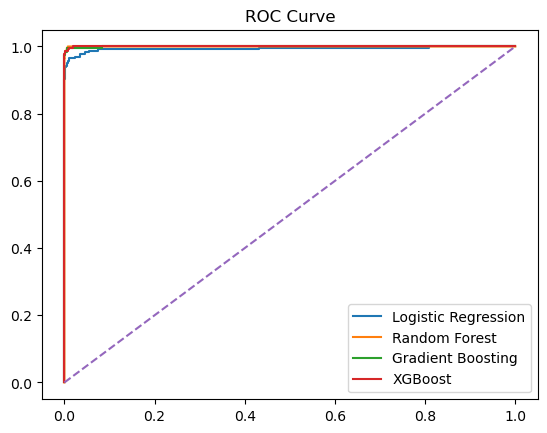

In [50]:
## evaluate all models
for name, model in trained_models.items():

    print("\n", "="*40)
    print(name)

    y_prob = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))

    ## cost-sensitive fraud optimization
    false_positive_cost = 100
    false_negative_cost = 10000

    thresholds = np.arange(0.1, 0.9, 0.05)

    best_threshold = 0.5
    lowest_cost = float('inf')

    for t in thresholds:

        y_pred_custom = (y_prob >= t).astype(int)

        cm = confusion_matrix(y_test, y_pred_custom)

        FP = cm[0,1]
        FN = cm[1,0]

        total_cost = FP * false_positive_cost + FN * false_negative_cost

        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = t

    print("Best threshold:", best_threshold)
    print("Minimum financial cost:", lowest_cost)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1],[0,1],'--')
plt.legend()
plt.title("ROC Curve")
plt.show()

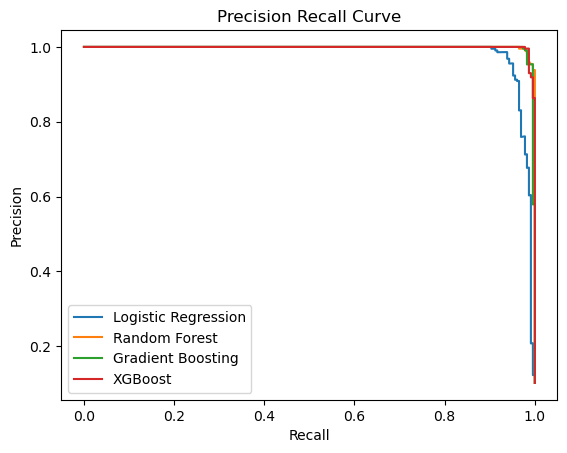

In [51]:
## precision recall curve
## very important for fraud detection type models
for name, model in trained_models.items():

    y_prob = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)

    plt.plot(recall, precision, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve")
plt.legend()
plt.show()

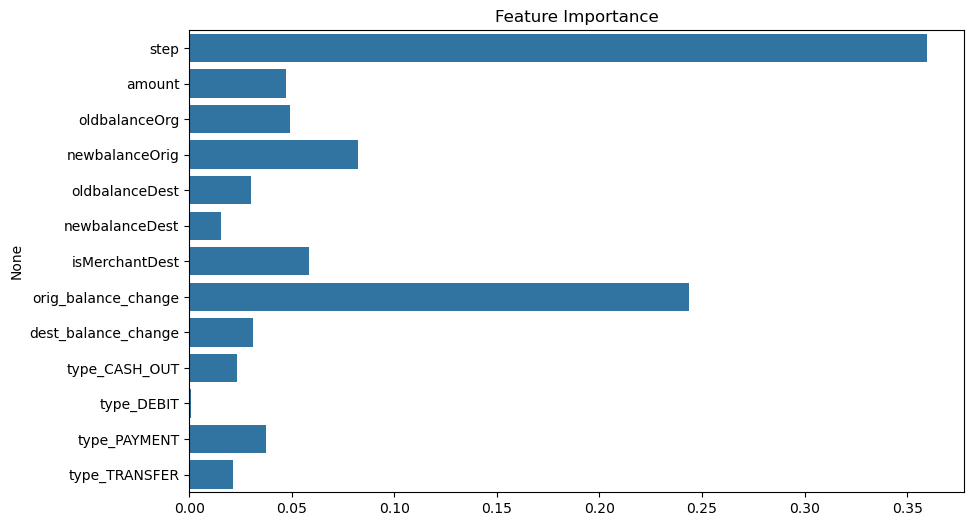

In [52]:
## feature Importance(tree models)
rf_model = trained_models["Random Forest"].named_steps['model']

plt.figure(figsize=(10,6))
sns.barplot(x=rf_model.feature_importances_, y=X.columns)
plt.title("Feature Importance")
plt.show()

In [53]:
## best model
best_model = trained_models["Random Forest"]
joblib.dump(best_model, "fraud_detection_model.pkl")

['fraud_detection_model.pkl']